In [1]:
!pip install transformers
! pip install -q pytorch-lightning

     |████████████████████████████████| 2.5MB 5.4MB/s 
     |████████████████████████████████| 3.3MB 46.8MB/s 
     |████████████████████████████████| 901kB 39.2MB/s 
     |████████████████████████████████| 819kB 5.5MB/s 
     |████████████████████████████████| 645kB 15.6MB/s 
     |████████████████████████████████| 829kB 19.7MB/s 
     |████████████████████████████████| 10.6MB 31.4MB/s 
     |████████████████████████████████| 235kB 40.3MB/s 
     |████████████████████████████████| 122kB 47.9MB/s 
     |████████████████████████████████| 1.3MB 39.1MB/s 
     |████████████████████████████████| 296kB 45.1MB/s 
     |████████████████████████████████| 143kB 46.2MB/s 
ERROR: tensorflow 2.5.0 has requirement tensorboard~=2.5, but you'll have tensorboard 2.4.1 which is incompatible.


In [ ]:
# Import all libraries
import pandas as pd
import numpy as np
import re

import os

# Huggingface transformers
import transformers
from transformers import BertModel,BertTokenizer,AdamW, get_linear_schedule_with_warmup, AutoModel, AutoTokenizer

import torch
from torch import nn ,cuda
from torch.utils.data import DataLoader,Dataset,RandomSampler, SequentialSampler

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.metrics.functional import accuracy, f1, auroc

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

#handling html data
from bs4 import BeautifulSoup

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
device

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
!ls /content/gdrive/MyDrive/

'Colab Notebooks'   lightning_logs


In [ ]:
# instalacija samo za google colab

import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import re

import nltk
from nltk.tokenize import WhitespaceTokenizer, WordPunctTokenizer, TreebankWordTokenizer
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, hamming_loss, jaccard_similarity_score
from transformers import DistilBertModel,DistilBertConfig, BertConfig, DistilBertTokenizer, AutoModel, AutoTokenizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.multioutput import MultiOutputClassifier

# from xgboost import XGBClassifier

import seaborn as sns

from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential, model_from_json
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM, SpatialDropout1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from keras.layers import Input
from keras.preprocessing.sequence import pad_sequences

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving Label Report - Anti-assignment, CIC (Group 3).xlsx to Label Report - Anti-assignment, CIC (Group 3).xlsx
Saving Label Report - Audit Rights.xlsx to Label Report - Audit Rights.xlsx
Saving Label Report - Covenant not to Sue_ Release of Claims.xlsx to Label Report - Covenant not to Sue_ Release of Claims.xlsx
Saving Label Report - Dates (Group 1).xlsx to Label Report - Dates (Group 1).xlsx
Saving Label Report - Document Name.xlsx to Label Report - Document Name.xlsx
Saving Label Report - Governing Law.xlsx to Label Report - Governing Law.xlsx
Saving Label Report - Insurance.xlsx to Label Report - Insurance.xlsx
Saving Label Report - IP Ownership Assignment.xlsx to Label Report - IP Ownership Assignment.xlsx
Saving Label Report - Joint IP Ownership.xlsx to Label Report - Joint IP Ownership.xlsx
Saving Label Report - Licenses (Group 4).xlsx to Label Report - Licenses (Group 4).xlsx
Saving Label Report - Liquidated Damages.xlsx to Label Report - Liquidated Damages.xlsx
Saving Label R

In [ ]:
# dataframe = pd.read_csv('CUAD_v1/master_clauses.csv')
dataframe = pd.read_csv('master_clauses.csv')
# dataframe.head()
# dataframe.columns
dataframe.head()
dataframe.rename(columns = {'Filename':'Clause'}, inplace = True)
dataframe.head()
dataframe.drop(dataframe.index, inplace=True)
for i in range(2,43,1):
    dataframe[dataframe.columns[i-1]] = pd.to_numeric(dataframe[dataframe.columns[i-1]])
    dataframe.drop(dataframe.columns[i],axis=1, inplace = True)   
dataframe.head()
len(dataframe.columns)

42

In [ ]:
# files = os.listdir('CUAD_v1/label_group_xlsx')
files = os.listdir('.')
for file in files:
    if (not(file.startswith("Label Report"))):
      continue
    file_path = file
    df_lb_group = pd.read_excel(file_path)
    print(file)
    if((file == "Label Report - Dates (Group 1).xlsx") or (file == "Label Report - Parties.xlsx")):
        print(file)
        df_lb_group.drop([col for col in df_lb_group.columns if 'Answer' in col],axis=1,inplace=True)
#         df = df[df.columns.drop(list(df.filter(regex='Answer')))]
#         df_lb_group.drop([df_lb_group.columns[2], df_lb_group.columns[4], df_lb_group.columns[6],
#                            df_lb_group.columns[8], df_lb_group.columns[10]],axis=1, inplace = True)
#     elif(file == "Label Report - Parties.xlsx"):
        
    df_lb_group.drop(df_lb_group.columns[0],axis=1, inplace = True)
    for column in df_lb_group.columns:
        lista = df_lb_group[column]
        lista.dropna(inplace = True)
        #     print(lista)
        for clauses in lista:
            clauses = re.sub(r'\(Page \d+\)', "", clauses)  
#             print(clauses)
            clauses_list = clauses.split('\n\n')
            for clause in clauses_list:
                num = (dataframe['Clause'] == clause).any()
                if num == 0:
                    new_row = [0] * 42
                    new_row[0] = clause
                    dataframe = dataframe.append(pd.Series(new_row, index=dataframe.columns[:len(new_row)]), ignore_index=True)
                dataframe[column][dataframe['Clause'] == clause] = 1

Label Report - Parties.xlsx
Label Report - Parties.xlsx


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Label Report - ROFR-ROFO-ROFN.xlsx
Label Report - Source Code Escrow.xlsx
Label Report - Insurance.xlsx
Label Report - Post-Termination Services.xlsx
Label Report - Non-Compete, Exclusivity, No-Solicit of Customers (Group 2).xlsx
Label Report - Price Restrictions.xlsx
Label Report - Audit Rights.xlsx
Label Report - Warranty Duration.xlsx
Label Report - Document Name.xlsx
Label Report - Unlimited-All-You-Can-Eat License.xlsx
Label Report - Anti-assignment, CIC (Group 3).xlsx
Label Report - Dates (Group 1).xlsx
Label Report - Dates (Group 1).xlsx
Label Report - Liquidated Damages.xlsx
Label Report - Minimum Commitment.xlsx
Label Report - Most Favored Nation.xlsx
Label Report - Volume Restriction.xlsx
Label Report - Governing Law.xlsx
Label Report - Covenant not to Sue_ Release of Claims.xlsx
Label Report - No-Solicit of Employees.xlsx
Label Report - Joint IP Ownership.xlsx
Label Report - Third Party Beneficiary.xlsx
Label Report - Uncapped Liability (Group 5).xlsx
Label Report - Revenue-

In [ ]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12203 entries, 0 to 12202
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Clause                              12203 non-null  object
 1   Document Name                       12203 non-null  int64 
 2   Parties                             12203 non-null  int64 
 3   Agreement Date                      12203 non-null  int64 
 4   Effective Date                      12203 non-null  int64 
 5   Expiration Date                     12203 non-null  int64 
 6   Renewal Term                        12203 non-null  int64 
 7   Notice Period To Terminate Renewal  12203 non-null  int64 
 8   Governing Law                       12203 non-null  int64 
 9   Most Favored Nation                 12203 non-null  int64 
 10  Competitive Restriction Exception   12203 non-null  int64 
 11  Non-Compete                         12203 non-null  in

In [ ]:
def pre_process(text):

  text = BeautifulSoup(text).get_text()
  
  # fetch alphabetic characters
  text = re.sub("[^a-zA-Z]", " ", text)

  # convert text to lower case
  text = text.lower()

  # split text into tokens to remove whitespaces
  tokens = text.split()

  return " ".join(tokens)

In [ ]:
#data pre-processing
def preprocess(sen):
      
  snowball = SnowballStemmer(language='english')

  # # Remove all the special characters
  document = re.sub(r'\W', ' ', str(sen))

  # remove all single characters
  document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)

  # Remove single characters from the start
  document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 

  # Substituting multiple spaces with single space
  document = re.sub(r'\s+', ' ', document, flags=re.I)

  # Removing prefixed 'b'
  document = re.sub(r'^b\s+', '', document)

  # Converting to Lowercase
  # document = document.lower()

  # Steamming
  document = document.split()

  document = [snowball.stem(word) for word in document]

  #Remove stop words
  #document = [word for word in document if not word in stopwords.words()]

  document = ' '.join(document)
  return document

In [ ]:
sentences = list(dataframe["Clause"])
docs = []
for sen in sentences:
    docs.append(preprocess(sen))
docs

['birch first global invest inc',
 'compani',
 'mount knowledg hold inc',
 'market affili',
 'ma',
 'roger cabl communic inc',
 'roger',
 'euromedia hold corp',
 'licensor',
 'convergtv inc',
 'convergtv',
 'fulucai product ltd',
 'produc',
 'psitech corpor',
 'licensor',
 'empir ventur inc',
 'license',
 'beij sun seven star cultur develop limit',
 'you on demand hold inc',
 'license',
 'rsl com primecal inc',
 'primecal',
 'deltathre com inc former known as delta three inc',
 'deltathre',
 'women com network inc',
 'women com',
 'ediet com inc',
 'ediet',
 'integr incorpor',
 'integr',
 'time life inc',
 'd a time life music',
 'tl',
 'marin mp llc',
 'lender',
 'arnold schwarzenegg',
 'endors',
 'fit public inc',
 'fit',
 'collect lender endors and fit are refer to as the as parti',
 'musclepharm corpor',
 'collect musclepharm or the compani',
 'skype communic a',
 'skype',
 'skype technolog a',
 'skype hold',
 'tom onlin bvi limit',
 'onlin bvi',
 'tom onlin inc',
 'tom hold',
 'te

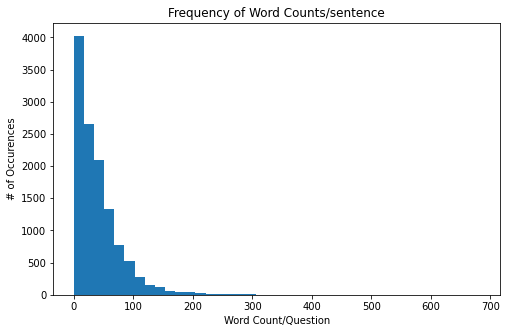

In [ ]:
word_cnt = [len(doc.split()) for doc in docs]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Word Count/Question')
plt.ylabel('# of Occurences')
plt.title("Frequency of Word Counts/sentence")
plt.show()

In [ ]:
labels = dataframe.drop(['Clause'],axis=1)
labels.head()
dataframe[labels.columns].sum()

Document Name                          289
Parties                               2234
Agreement Date                         466
Effective Date                         413
Expiration Date                        470
Renewal Term                           217
Notice Period To Terminate Renewal     123
Governing Law                          453
Most Favored Nation                     36
Competitive Restriction Exception      128
Non-Compete                            268
Exclusivity                            431
No-Solicit Of Customers                 47
No-Solicit Of Employees                 85
Non-Disparagement                       56
Termination For Convenience            233
Rofr/Rofo/Rofn                         370
Change Of Control                      236
Anti-Assignment                        639
Revenue/Profit Sharing                 505
Price Restrictions                      28
Minimum Commitment                     486
Volume Restriction                     177
IP Ownershi

In [ ]:
LABEL_COLUMNS = labels.columns
LABEL_COLUMNS

Index(['Document Name', 'Parties', 'Agreement Date', 'Effective Date',
       'Expiration Date', 'Renewal Term', 'Notice Period To Terminate Renewal',
       'Governing Law', 'Most Favored Nation',
       'Competitive Restriction Exception', 'Non-Compete', 'Exclusivity',
       'No-Solicit Of Customers', 'No-Solicit Of Employees',
       'Non-Disparagement', 'Termination For Convenience', 'Rofr/Rofo/Rofn',
       'Change Of Control', 'Anti-Assignment', 'Revenue/Profit Sharing',
       'Price Restrictions', 'Minimum Commitment', 'Volume Restriction',
       'IP Ownership Assignment', 'Joint IP Ownership', 'License Grant',
       'Non-Transferable License', 'Affiliate License-Licensor',
       'Affiliate License-Licensee', 'Unlimited/All-You-Can-Eat-License',
       'Irrevocable Or Perpetual License', 'Source Code Escrow',
       'Post-Termination Services', 'Audit Rights', 'Uncapped Liability',
       'Cap On Liability', 'Liquidated Damages', 'Warranty Duration',
       'Insurance', 'Co

In [ ]:
dataframe['Clause'] = dataframe['Clause'].apply(preprocess)

In [ ]:
dataframe.head()

,Clause,Document Name,Parties,Agreement Date,Effective Date,Expiration Date,Renewal Term,Notice Period To Terminate Renewal,Governing Law,Most Favored Nation,Competitive Restriction Exception,Non-Compete,Exclusivity,No-Solicit Of Customers,No-Solicit Of Employees,Non-Disparagement,Termination For Convenience,Rofr/Rofo/Rofn,Change Of Control,Anti-Assignment,Revenue/Profit Sharing,Price Restrictions,Minimum Commitment,Volume Restriction,IP Ownership Assignment,Joint IP Ownership,License Grant,Non-Transferable License,Affiliate License-Licensor,Affiliate License-Licensee,Unlimited/All-You-Can-Eat-License,Irrevocable Or Perpetual License,Source Code Escrow,Post-Termination Services,Audit Rights,Uncapped Liability,Cap On Liability,Liquidated Damages,Warranty Duration,Insurance,Covenant Not To Sue,Third Party Beneficiary
0,birch first global invest inc,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,compani,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,mount knowledg hold inc,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,market affili,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,ma,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
tr_df, test_df = train_test_split(dataframe, test_size=0.2, random_state=42)
train_df1, val_df = train_test_split(tr_df, test_size=0.2, random_state=42)

In [ ]:
val_df[LABEL_COLUMNS].sum()

Document Name                          42
Parties                               345
Agreement Date                         71
Effective Date                         69
Expiration Date                        92
Renewal Term                           40
Notice Period To Terminate Renewal     20
Governing Law                          80
Most Favored Nation                     5
Competitive Restriction Exception      30
Non-Compete                            38
Exclusivity                            78
No-Solicit Of Customers                 4
No-Solicit Of Employees                19
Non-Disparagement                      11
Termination For Convenience            43
Rofr/Rofo/Rofn                         50
Change Of Control                      45
Anti-Assignment                       103
Revenue/Profit Sharing                 86
Price Restrictions                      5
Minimum Commitment                     80
Volume Restriction                     29
IP Ownership Assignment           

In [ ]:
X = train_df1["Clause"].values
y = train_df1[LABEL_COLUMNS].values
# X = pd.DataFrame(X)
X = X.reshape(-1, 1)

In [ ]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
X_ros, y_ros = ros.fit_sample(X, y)
X_df = pd.DataFrame(X_ros)
y_df = pd.DataFrame(y_ros)
train_df = pd.concat([X_df, y_df], axis=1)
train_df.columns = dataframe.columns
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58876 entries, 0 to 58875
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Clause                              58876 non-null  object
 1   Document Name                       58876 non-null  int64 
 2   Parties                             58876 non-null  int64 
 3   Agreement Date                      58876 non-null  int64 
 4   Effective Date                      58876 non-null  int64 
 5   Expiration Date                     58876 non-null  int64 
 6   Renewal Term                        58876 non-null  int64 
 7   Notice Period To Terminate Renewal  58876 non-null  int64 
 8   Governing Law                       58876 non-null  int64 
 9   Most Favored Nation                 58876 non-null  int64 
 10  Competitive Restriction Exception   58876 non-null  int64 
 11  Non-Compete                         58876 non-null  in

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1953 entries, 11538 to 7479
Data columns (total 42 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   Clause                              1953 non-null   object
 1   Document Name                       1953 non-null   int64 
 2   Parties                             1953 non-null   int64 
 3   Agreement Date                      1953 non-null   int64 
 4   Effective Date                      1953 non-null   int64 
 5   Expiration Date                     1953 non-null   int64 
 6   Renewal Term                        1953 non-null   int64 
 7   Notice Period To Terminate Renewal  1953 non-null   int64 
 8   Governing Law                       1953 non-null   int64 
 9   Most Favored Nation                 1953 non-null   int64 
 10  Competitive Restriction Exception   1953 non-null   int64 
 11  Non-Compete                         1953 non-null   

In [ ]:
BERT_MODEL_NAME = "nlpaueb/legal-bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL_NAME)

In [ ]:
token_counts = []
for _, row in dataframe.iterrows():
  token_count = len(tokenizer.encode(
    row["Clause"],
    max_length=512,
    truncation=True
  ))
  token_counts.append(token_count)

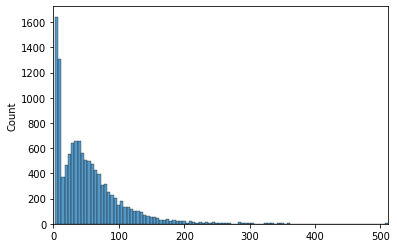

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

In [ ]:
MAX_TOKEN_COUNT = 512

In [ ]:
class ClausesDataset(Dataset):
  def __init__(
    self,
    data: pd.DataFrame,
    tokenizer: BertTokenizer,
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]
    clause_text = data_row.Clause
    labels = data_row[LABEL_COLUMNS]
    encoding = self.tokenizer.encode_plus(
      clause_text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    return dict(
      clause_text=clause_text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

In [ ]:
train_dataset = ClausesDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['clause_text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
bert_model =  AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


(torch.Size([8, 512]), torch.Size([8, 512]))

In [ ]:
bert_model.config.hidden_size

768

In [ ]:
class ClausesDataModule(pl.LightningDataModule):
  def __init__(self, train_df, val_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = ClausesDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.val_dataset = ClausesDataset(
      self.val_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = ClausesDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )
    
  def val_dataloader(self):
    return DataLoader(
      self.val_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

In [ ]:
N_EPOCHS = 2
BATCH_SIZE = 12
data_module = ClausesDataModule(
  train_df,
  val_df,
  test_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

In [ ]:
class ClausesTagger(pl.LightningModule):
  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = AutoModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)
    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)
    for i, name in enumerate(LABEL_COLUMNS):
      class_roc_auc = auroc(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)
  
  def configure_optimizers(self):
    optimizer = AdamW(self.parameters(), lr=2e-5)
    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )
    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(1962, 9812)

In [ ]:
# model = ClausesTagger(
#   n_classes=len(LABEL_COLUMNS),
#   n_warmup_steps=warmup_steps,
#   n_training_steps=total_training_steps
# )

model = ClausesTagger.load_from_checkpoint(
  # checkpoint_callback.best_model_path,
  'gdrive/My Drive/lightning_logs/clauses-mixed/version_0/checkpoints/Clauses-epoch=01.ckpt',
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)
# model.n_warmup_steps = warmup_steps
# model.n_training_steps = total_training_steps
model.eval()

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


ClausesTagger(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [ ]:
checkpoint_callback = ModelCheckpoint(
  filename='Clauses-{epoch:02d}',
  save_top_k=3,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

In [ ]:
logger = TensorBoardLogger("gdrive/My Drive/lightning_logs", name="clauses-mixed-2")

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  # default_root_dir='/content/gdrive/My Drive',
  # checkpoint_callback=checkpoint_callback,
  callbacks=[checkpoint_callback,early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

MisconfigurationException: ignored

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 31.5 K
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
438.055   Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)
/usr/local/lib/python3.7/dist-packages/torchmetrics/utilities/prints.py:36: UserWarning: `pos_label` automatically set 1.
  warnings.warn(*args, **kwargs)


Epoch 0, global step 4834: val_loss reached 0.04305 (best 0.04305), saving model to "gdrive/My Drive/lightning_logs/clauses-mixed/version_0/checkpoints/Clauses-epoch=00.ckpt" as top 3


Epoch 1, global step 9669: val_loss reached 0.03976 (best 0.03976), saving model to "gdrive/My Drive/lightning_logs/clauses-mixed/version_0/checkpoints/Clauses-epoch=01.ckpt" as top 3


In [ ]:
# trainer.validate()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'test_loss': 0.047953587025403976, 'val_loss': 0.03761361911892891}
--------------------------------------------------------------------------------


[{'test_loss': 0.047953587025403976, 'val_loss': 0.03761361911892891}]

In [ ]:

# trainer.test()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.037015438079833984, 'val_loss': 0.03761361911892891}
--------------------------------------------------------------------------------


[{'test_loss': 0.037015438079833984, 'val_loss': 0.03761361911892891}]

In [ ]:
checkpoint_callback.best_model_path

'gdrive/My Drive/lightning_logs/clauses-mixed/version_2/checkpoints/Clauses-epoch=00.ckpt'

In [ ]:
trained_model = ClausesTagger.load_from_checkpoint(
  'gdrive/My Drive/lightning_logs/clauses-mixed/version_0/checkpoints/Clauses-epoch=01.ckpt',
  # checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at nlpaueb/legal-bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


TRAIN WITH OVERSAMPLING

In [ ]:
test_comment = test_df.iloc[2].Clause
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

Document Name: 0.0035202940925955772
Parties: 0.9761008620262146
Agreement Date: 0.0033066610340029
Effective Date: 0.0013256933307275176
Expiration Date: 0.00039045067387633026
Renewal Term: 0.0011731135891750455
Notice Period To Terminate Renewal: 0.0005818185163661838
Governing Law: 0.0009865786414593458
Most Favored Nation: 0.0005030091851949692
Competitive Restriction Exception: 0.00032484778785146773
Non-Compete: 0.00036269411793909967
Exclusivity: 0.0029194606468081474
No-Solicit Of Customers: 0.00028568183188326657
No-Solicit Of Employees: 0.0008156989933922887
Non-Disparagement: 0.0014488511951640248
Termination For Convenience: 0.0004904829547740519
Rofr/Rofo/Rofn: 0.0005772977601736784
Change Of Control: 0.0006852268124930561
Anti-Assignment: 0.0009678246569819748
Revenue/Profit Sharing: 0.0015960050513967872
Price Restrictions: 0.0013901739148423076
Minimum Commitment: 0.0011932025663554668
Volume Restriction: 0.0026913457550108433
IP Ownership Assignment: 0.000597065547481

In [ ]:
test_df.iloc[2]

Clause                                bunker one
Document Name                                  0
Parties                                        1
Agreement Date                                 0
Effective Date                                 0
Expiration Date                                0
Renewal Term                                   0
Notice Period To Terminate Renewal             0
Governing Law                                  0
Most Favored Nation                            0
Competitive Restriction Exception              0
Non-Compete                                    0
Exclusivity                                    0
No-Solicit Of Customers                        0
No-Solicit Of Employees                        0
Non-Disparagement                              0
Termination For Convenience                    0
Rofr/Rofo/Rofn                                 0
Change Of Control                              0
Anti-Assignment                                0
Revenue/Profit Shari

In [ ]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ClausesDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
threshold  = np.arange(0.3,0.7,0.01)
threshold

array([0.3 , 0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 ,
       0.41, 0.42, 0.43, 0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51,
       0.52, 0.53, 0.54, 0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62,
       0.63, 0.64, 0.65, 0.66, 0.67, 0.68, 0.69])

In [ ]:
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = labels.numpy()


for THRESHOLD in threshold: 
    upper, lower = 1, 0
    y_pred = predictions.numpy()
    y_pred = np.where(y_pred > THRESHOLD, upper, lower)
    # print(classification_report(
    #   y_true,
    #   y_pred,
    #   target_names=LABEL_COLUMNS,
    #   zero_division=0
    # ))

    scores.append(f1_score(y_true,y_pred, average='macro'))

print(scores)

[0.8183217189163254, 0.8182133892756325, 0.8182133892756325, 0.8185272691626833, 0.8188226910608924, 0.8176231580517014, 0.8187689228964214, 0.8194165385372638, 0.8191032465124914, 0.8192515154723845, 0.8191090318210393, 0.8189845704944836, 0.8191079665678153, 0.8189703551713898, 0.818212319723665, 0.8180117832887014, 0.8181449484134562, 0.8181112384510761, 0.8166679121460049, 0.8151640721390532, 0.8150238080385838, 0.8147760409803905, 0.8144234691378404, 0.814794144615449, 0.814794144615449, 0.8156220390866761, 0.8154794060813987, 0.8153361718761462, 0.815413985982661, 0.815413985982661, 0.8155488713266055, 0.8160579058908096, 0.8161720122950317, 0.8161720122950317, 0.8163789598190522, 0.8168924386380509, 0.8168924386380509, 0.8167328962364527, 0.8168659339304659, 0.8169238824952465]


In [ ]:
THRESHOLD = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {THRESHOLD}')

Optimal Threshold Value = 0.37000000000000005


In [ ]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ClausesDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `accuracy` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.accuracy.accuracy`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


tensor(0.9941)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Document Name: 1.0
Parties: 0.9990584850311279
Agreement Date: 0.9993813633918762
Effective Date: 0.9909457564353943
Expiration Date: 0.9981347918510437
Renewal Term: 0.9960557222366333
Notice Period To Terminate Renewal: 0.9665563106536865
Governing Law: 1.0
Most Favored Nation: 0.999958872795105
Competitive Restriction Exception: 0.997145414352417
Non-Compete: 0.9711129069328308
Exclusivity: 0.9745615720748901
No-Solicit Of Customers: 0.9939475655555725


/usr/local/lib/python3.7/dist-packages/deprecate/deprecation.py:115: LightningDeprecationWarning: The `auroc` was deprecated since v1.3.0 in favor of `torchmetrics.functional.classification.auroc.auroc`. It will be removed in v1.5.0.
  stream(template_mgs % msg_args)


No-Solicit Of Employees: 0.9223273992538452
Non-Disparagement: 0.99991774559021
Termination For Convenience: 0.9840567111968994
Rofr/Rofo/Rofn: 0.9928593635559082
Change Of Control: 0.9785572290420532
Anti-Assignment: 0.9833863377571106
Revenue/Profit Sharing: 0.9971049427986145
Price Restrictions: 0.9903940558433533
Minimum Commitment: 0.9890718460083008
Volume Restriction: 0.9771988391876221
IP Ownership Assignment: 0.9969130754470825
Joint IP Ownership: 0.9919483661651611
License Grant: 0.9796929955482483
Non-Transferable License: 0.9309953451156616
Affiliate License-Licensor: 0.9378226399421692
Affiliate License-Licensee: 0.8046383857727051
Unlimited/All-You-Can-Eat-License: 0.9245790839195251
Irrevocable Or Perpetual License: 0.8804160952568054
Source Code Escrow: 0.9843506217002869
Post-Termination Services: 0.966874897480011
Audit Rights: 0.9999130964279175
Uncapped Liability: 0.9981820583343506
Cap On Liability: 0.996317982673645
Liquidated Damages: 0.9534768462181091
Warranty 

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                                    precision    recall  f1-score   support

                     Document Name       1.00      0.97      0.98        60
                           Parties       0.97      1.00      0.98       453
                    Agreement Date       0.98      0.94      0.96        89
                    Effective Date       0.82      0.34      0.48        79
                   Expiration Date       0.94      0.92      0.93        87
                      Renewal Term       0.97      0.75      0.85        44
Notice Period To Terminate Renewal       1.00      0.21      0.34        24
                     Governing Law       1.00      0.99      0.99        93
               Most Favored Nation       0.90      0.90      0.90        10
 Competitive Restriction Exception       0.74      0.94      0.83        18
                       Non-Compete       0.91      0.78      0.84        54
                       Exclusivity       0.85      0.83      0.84        90
           

TRAIN WITOUT OVERSAMPLING 10 EPOCHS

In [ ]:
test_comment = test_df.iloc[2].Clause
encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()
for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

Document Name: 0.005647384561598301
Parties: 0.008333409205079079
Agreement Date: 0.003518260782584548
Effective Date: 0.0050291153602302074
Expiration Date: 0.00781815592199564
Renewal Term: 0.0019154449691995978
Notice Period To Terminate Renewal: 0.0020841555669903755
Governing Law: 0.0031104572117328644
Most Favored Nation: 0.003407189855352044
Competitive Restriction Exception: 0.00263571715913713
Non-Compete: 0.0032725080382078886
Exclusivity: 0.004834036808460951
No-Solicit Of Customers: 0.0044156331568956375
No-Solicit Of Employees: 0.004291489254683256
Non-Disparagement: 0.005794713739305735
Termination For Convenience: 0.0027596240397542715
Rofr/Rofo/Rofn: 0.0006693281466141343
Change Of Control: 0.006527547258883715
Anti-Assignment: 0.00802773330360651
Revenue/Profit Sharing: 0.010473182424902916
Price Restrictions: 0.001301765558309853
Minimum Commitment: 0.0030022754799574614
Volume Restriction: 0.0010488518746569753
IP Ownership Assignment: 0.011022549122571945
Joint IP O

In [ ]:
i = 0;
for row in test_df[LABEL_COLUMNS].values:
  if sum(row)>=2:
    break
  i += 1
# print (i)
test_df.iloc[2]

2


In [ ]:
# THRESHOLD = 0.3
# test_comment = test_comment = test_df.iloc[55].Clause
# encoding = tokenizer.encode_plus(
#   test_comment,
#   add_special_tokens=True,
#   max_length=512,
#   return_token_type_ids=False,
#   padding="max_length",
#   return_attention_mask=True,
#   return_tensors='pt',
# )
# _, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
# test_prediction = test_prediction.flatten().numpy()
# for label, prediction in zip(LABEL_COLUMNS, test_prediction):
#   if prediction < THRESHOLD:
#     continue
#   print(f"{label}: {prediction}")

In [ ]:
# test_df.iloc[55]

In [ ]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ClausesDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
threshold  = np.arange(0.35,0.7,0.01)
threshold

array([0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44, 0.45,
       0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55, 0.56,
       0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66, 0.67,
       0.68, 0.69])

In [ ]:
scores=[] # Store the list of f1 scores for prediction on each threshold

#convert labels to 1D array
y_true = labels.numpy()


for THRESHOLD in threshold: 
    upper, lower = 1, 0
    y_pred = predictions.numpy()
    y_pred = np.where(y_pred > THRESHOLD, upper, lower)
    # print(classification_report(
    #   y_true,
    #   y_pred,
    #   target_names=LABEL_COLUMNS,
    #   zero_division=0
    # ))

    scores.append(f1_score(y_true,y_pred, average='macro'))

print(scores)

[0.7538604561334102, 0.7523598451076493, 0.755772269022952, 0.751166109528257, 0.7483410251377494, 0.7403377188576515, 0.738479762572066, 0.7365769426038306, 0.734982839171979, 0.7348249919286469, 0.7328977384111888, 0.7194490259181925, 0.714080942005063, 0.713671532322753, 0.7133862611205688, 0.7141576076955183, 0.7136498144239588, 0.7131056029552708, 0.7137611367243878, 0.7083042763009056, 0.7073648790847044, 0.7067328007994447, 0.7050878276534238, 0.7041692134279204, 0.699521333459251, 0.6995171326812925, 0.698033675399464, 0.6974876249093038, 0.6971908351418011, 0.6970587870072844, 0.6956787608196994, 0.6922178890911341, 0.6923067090491701, 0.6904643297855477, 0.687287775112808]


In [ ]:
THRESHOLD = threshold[scores.index(max(scores))]
print(f'Optimal Threshold Value = {THRESHOLD}')

Optimal Threshold Value = 0.37


In [ ]:
# THRESHOLD = 0.4

In [ ]:
from tqdm.auto import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)
test_dataset = ClausesDataset(
  test_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)
predictions = []
labels = []
for item in tqdm(test_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device),
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())
predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.9918)

In [ ]:
print("AUROC per tag")
for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  print(f"{name}: {tag_auroc}")

AUROC per tag
Document Name: 0.9863110780715942
Parties: 0.9994063377380371
Agreement Date: 0.9941349029541016
Effective Date: 0.9801133871078491
Expiration Date: 0.9890906810760498
Renewal Term: 0.9853934049606323
Notice Period To Terminate Renewal: 0.9957003593444824
Governing Law: 0.9998056292533875
Most Favored Nation: 0.9965120553970337
Competitive Restriction Exception: 0.953747570514679
Non-Compete: 0.944270133972168
Exclusivity: 0.9651370644569397
No-Solicit Of Customers: 0.9904513955116272
No-Solicit Of Employees: 0.9997645616531372
Non-Disparagement: 1.0
Termination For Convenience: 0.996837317943573
Rofr/Rofo/Rofn: 0.9782033562660217
Change Of Control: 0.9801246523857117
Anti-Assignment: 0.9887362718582153
Revenue/Profit Sharing: 0.9752994775772095
Price Restrictions: 0.9920699596405029
Minimum Commitment: 0.9743081331253052
Volume Restriction: 0.989070475101471
IP Ownership Assignment: 0.9923611879348755
Joint IP Ownership: 0.9939433336257935
License Grant: 0.98308193683624

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()
upper, lower = 1, 0
y_pred = np.where(y_pred > THRESHOLD, upper, lower)
print(classification_report(
  y_true,
  y_pred,
  target_names=LABEL_COLUMNS,
  zero_division=0
))

                                    precision    recall  f1-score   support

                     Document Name       0.98      0.95      0.96        58
                           Parties       0.98      0.99      0.99       442
                    Agreement Date       0.89      0.93      0.91        92
                    Effective Date       0.61      0.84      0.71        93
                   Expiration Date       0.84      0.87      0.86       109
                      Renewal Term       0.71      0.77      0.73        47
Notice Period To Terminate Renewal       0.63      0.61      0.62        28
                     Governing Law       0.97      1.00      0.98        92
               Most Favored Nation       0.75      0.75      0.75         4
 Competitive Restriction Exception       0.57      0.29      0.38        28
                       Non-Compete       0.68      0.68      0.68        50
                       Exclusivity       0.55      0.64      0.59        72
           

In [ ]:
labels_test = test_df.drop(['Clause'],axis=1)
labels_test.head()
test_df[LABEL_COLUMNS].sum()

Document Name                          58
Parties                               442
Agreement Date                         92
Effective Date                         93
Expiration Date                       109
Renewal Term                           47
Notice Period To Terminate Renewal     28
Governing Law                          92
Most Favored Nation                     4
Competitive Restriction Exception      28
Non-Compete                            50
Exclusivity                            72
No-Solicit Of Customers                 9
No-Solicit Of Employees                14
Non-Disparagement                       9
Termination For Convenience            45
Rofr/Rofo/Rofn                         85
Change Of Control                      53
Anti-Assignment                       126
Revenue/Profit Sharing                 92
Price Restrictions                      3
Minimum Commitment                     97
Volume Restriction                     24
IP Ownership Assignment           

In [ ]:
print(classification_report(
  y_true,
  y_pred
))

              precision    recall  f1-score   support

           0       0.98      0.95      0.96        58
           1       0.99      0.99      0.99       442
           2       0.89      0.92      0.91        92
           3       0.77      0.43      0.55        93
           4       0.89      0.83      0.86       109
           5       0.79      0.70      0.74        47
           6       0.81      0.61      0.69        28
           7       0.97      0.99      0.98        92
           8       0.67      0.50      0.57         4
           9       0.50      0.04      0.07        28
          10       0.67      0.60      0.63        50
          11       0.56      0.56      0.56        72
          12       0.00      0.00      0.00         9
          13       0.88      1.00      0.93        14
          14       1.00      0.89      0.94         9
          15       0.83      0.78      0.80        45
          16       0.89      0.78      0.83        85
          17       0.73    

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
